In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N = 1000

In [3]:
ip = np.random.rand(N) > 0.5
ip = ip.astype(int)

In [4]:
s = 2 * ip - 1

In [5]:
Es = 1

In [6]:
eb_no_db = np.arange(0,25)

In [7]:
ber_RxMF_SVD_P = np.zeros(len(eb_no_db))

In [8]:
def design_precoder_extra(nTx,S,V,noise_variance):
    
    S1 = S[0]
    
    S2 = S[1]
    
    S = [S1, S2]
    
    q_opt = []
    
    mu = (Es + (noise_variance/np.square(S1)))
    
    
    q1 = mu - (noise_variance/np.square(S1))
    
    q_opt.append(q1)
    
    summation_part = 0
    
    for kk in range(len(S)):
        
        mu = Es + (noise_variance/np.square(S1))
         
        q1 = mu - (noise_variance/np.square(S1))
        
        if(q1 > 0):
              
              q_opt.append(q1)
              
        summation_part = summation_part + (noise_variance / S[kk])
              
    mu = (1/len(S)) * summation_part
    q_opt = []
    for mm in range(len(S)):
        
        qi = mu - (noise_variance/np.square(S[mm]))
        
        if(qi > 0):
            
            q_opt.append(qi)
        else:
            q_opt = []
            
            q_opt.append(q1)
            
            break
              
    q_sqrt = np.sqrt(q_opt)   
    
    Q_matrix = np.pad(q_sqrt, (0, nTx - len(q_sqrt)), mode='constant', constant_values=0)
    
    Q_matrix = np.diag(Q_matrix)
    
    Ns = len(q_opt)
    
    P = V[:,0:Ns] @ Q_matrix[0:Ns,0:Ns]
    
    return P
    
  
    
    
    

In [9]:
def sigma_two(noise_variance,S1,S2,q_optimal_1):
    
    S = [ S1 , S2 ]
    
    q_optimal_1 = q_optimal_1

    sigma_two_q  = []
    
    summation_part = 0
    
    for kk in range(len(S)):
        
        summation_part = summation_part +  (noise_variance/np.square(S[kk]))
        
    mu = (1/len(S))* (Es + summation_part)
    
    for mm in range(len(S)):
        
        qi = mu - (noise_variance/np.square(S[mm]))
        
        if(qi > 0):
            
            sigma_two_q.append(qi)
            
        else:
            sigma_two_q = []
            
            sigma_two_q = q_optimal_1.copy()
            
            break
            
    return sigma_two_q

In [10]:
def sigma_one(noise_variance,S1):
    
    
    S = [S1]
    
    
    sigma_one_q = []
    
    summation_part = noise_variance / np.square(S1)
    
    mu = (1/len(S)) * (Es + summation_part )
    
    q_optimal = mu - (noise_variance / np.square(S1))
    
    if q_optimal > 0 :
        
        sigma_one_q.append(q_optimal)
        
    
    
    return sigma_one_q

In [11]:
def diagonalQ(S,noise_variance):
    
    
    S1 = S[0]
    
    S2 = S[1]
    
    S = [S1, S2]
    
    q_optimal_1 = sigma_one(noise_variance,S1)
    
    q_optimal_2 = sigma_two(noise_variance,S1,S2,q_optimal_1)
    
    return q_optimal_2

In [12]:
def design_precoder(nTx,S,V,noise_variance):
    
    Q = diagonalQ(S,noise_variance)
    
    
    Ns = len(Q)

    q_sqrt = np.sqrt(Q)
     
    q_sqrt = q_sqrt[:nTx]
        
    q_sqrt = np.pad(q_sqrt, (0, nTx - len(q_sqrt)), mode='constant', constant_values=0)
        
    Q_matrix = np.diag(q_sqrt)
       
    precoder = V[:,0:Ns] @ Q_matrix[0:Ns,0:Ns]
 
    
    return precoder

In [13]:
def calculate_ber_Rx_SVD_P(noise_variance,jj,nTx,nRx,Rz,Rz_inverse,equalization_name):
    
    equalize_bits = []
    
    effective_bits = []
    
    for ii in range(N//2):
        
        H = (1/np.sqrt(2)) * (np.random.randn(nRx,nTx) + 1j * np.random.randn(nRx,nTx))
        
        H_hermitian = np.conjugate(H)
        
        H_hermitian = np.transpose(H_hermitian)
        
        U , S , Vh = np.linalg.svd(H, full_matrices=False)
        
        V = np.conjugate(Vh)
        
        V = np.transpose(V)
        
        n = (1/np.sqrt(2)) * (np.random.randn(2,1) + 1j * np.random.randn(2,1))
        
        x1 = s[2 * ii]
        
        x2 = s[2 * ii + 1]
        
        x =np.array([[x1],[x2]])
        
        P = design_precoder(nTx,S,V,noise_variance)
        
        P_hermitian = np.conjugate(P)
        
        P_hermitian = np.transpose(P_hermitian)
        
        if P.shape == (2,1):
            
            effective_bits.append(x1)
            
            x = np.array([[x1]])
            
            y = H @ P @ x + n * (10 ** (-eb_no_db[jj] / 20))
            
            W = np.linalg.inv(P_hermitian @ H_hermitian @ Rz_inverse @ H @ P)@ P_hermitian @ H_hermitian @ Rz_inverse
            
            x_hat = np.dot(W, y)
            
            x_hat = np.real(x_hat > 0).astype(int)
             
            equalize_bits.append(x_hat[0, 0])
            
        elif P.shape == (2,2):
            
            effective_bits.append(x1)
            
            effective_bits.append(x2)
            
            y = H @ P @ x + n * (10 ** (-eb_no_db[jj] / 20))
            
            W = np.linalg.inv(P_hermitian @ H_hermitian @ Rz_inverse @ H @ P)@ P_hermitian @ H_hermitian @ Rz_inverse
            
            x_hat = np.dot(W, y)
            
            x_hat = np.real(x_hat > 0).astype(int)
                
            equalize_bits.append(x_hat[0, 0])
            
            equalize_bits.append(x_hat[1, 0])
            
    nErr = np.sum(effective_bits != equalize_bits)
    
    nErr_rate = nErr / len(effective_bits)
    
    return nErr_rate
    

In [14]:
def RxMF_SVD_P():
    
    for jj in range(len(eb_no_db)):
        
        snr = 10**(eb_no_db[jj] / 10)
         
        noise_variance = (1/snr)
        
        nTx = 2
        
        nRx = 2
        
        Rz = noise_variance * np.eye(nRx)
        
        Rz_inverse = np.linalg.inv(Rz)
        
        bit_error = calculate_ber_Rx_SVD_P(noise_variance,jj,nTx,nRx,Rz,Rz_inverse,"MF")
        
        ber_RxMF_SVD_P[jj] = bit_error
        
    return ber_RxMF_SVD_P
        
    
        
        
        
       

[0.00163399 0.00155521 0.00144092 0.00136612 0.00133869 0.001287
 0.00122399 0.00118064 0.00115607 0.00112233 0.00110132 0.00109051
 0.00105485 0.00104712 0.00104712 0.00102041 0.00102987 0.00102564
 0.0010101  0.00101112 0.00101523 0.00101317 0.00100705 0.001002
 0.00100604]


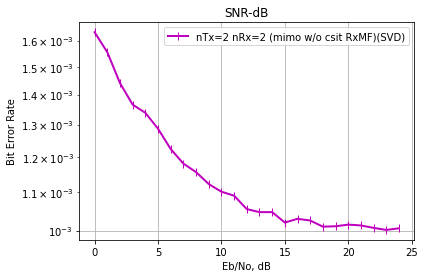

In [15]:
rxmf = RxMF_SVD_P()

print(rxmf)

plt.figure()

plt.semilogy(eb_no_db, rxmf, 'm|-', linewidth=2, markersize=8, label='nTx=2 nRx=2 (mimo w/o csit RxMF)(SVD)')

plt.grid(True)
plt.legend()
plt.xlabel('Eb/No, dB')
plt.ylabel('Bit Error Rate')
plt.title('SNR-dB')
plt.show()